<a href="https://colab.research.google.com/github/cosmina98/PhD/blob/main/2022/Sep/GAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
!pip install plotnine --quiet
!pip install torch_geometric  --quiet
!pip install torch_geometric  --quiet
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html --quiet
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html  --quiet
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git   --quiet

1.12.1+cu113
     |████████████████████████████████| 467 kB 5.3 MB/s 
     |████████████████████████████████| 7.9 MB 2.9 MB/s 
     |████████████████████████████████| 3.5 MB 2.9 MB/s 


In [32]:
import torch.nn.functional as F
from torch.nn import Parameter as Param
from torch.nn import Parameter, Module
from torch.nn import Sequential, Linear, ReLU
from torch.optim import Optimizer
from torch import Tensor
from torch import nn
from torch.optim.sgd import SGD
import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv,ChebConv,GATConv
from torch_geometric.utils import get_laplacian
from torch_geometric.utils import to_scipy_sparse_matrix
from torch_geometric.nn import GatedGraphConv
from torch_geometric.nn import MessagePassing, SAGEConv, GINConv, global_add_pool
from torch_geometric.nn.inits import uniform
from torch.optim.adam import Adam

import os.path as osp


from typing import Callable, List, Optional, Tuple
from typing_extensions import Literal, TypedDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score
from tqdm.notebook import trange, tqdm
import copy
import random
import time
import  math
import itertools
from functools import reduce
import operator
import torch.utils.data as data_utils
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix
from torch.utils.data import Subset
from plotnine import ggplot, geom_line, aes, xlab, theme, element_blank, ggtitle
from collections import OrderedDict
from typing_extensions import Literal, TypedDict
from torch_sparse import SparseTensor
from torch_scatter import gather_csr, scatter, segment_csr

import inspect

from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available()  else 'cpu')

#Dataset Imports 

In [4]:
dataset=list(range(3))
i=0
for dataset_name in ['Cora','CiteSeer','PubMed']:
    dataset[i] = Planetoid('/tmp/dataset_name', name=dataset_name,transform=T.NormalizeFeatures())
    num_nodes = dataset[i].data.num_nodes
    num_edges = dataset[i].data.num_edges // 2
    train_len = dataset[i][0].train_mask.sum()
    val_len = dataset[i][0].val_mask.sum()
    test_len = dataset[i][0].test_mask.sum()
    other_len = num_nodes - train_len - val_len - test_len
    print(f"Dataset: {dataset[i].name}")
    print(f"Num. nodes: {num_nodes} (train={train_len}, val={val_len}, test={test_len}, other={other_len})")
    print(f"Num. edges: {num_edges}")
    print(f"Num. node features: {dataset[i].num_node_features}")
    print(f"Num. classes: {dataset[i].num_classes}")
    print(f"Dataset len.: {dataset[i].len()}")
    i=i+1
    print(" ")

Dataset: Cora
Num. nodes: 2708 (train=140, val=500, test=1000, other=1068)
Num. edges: 5278
Num. node features: 1433
Num. classes: 7
Dataset len.: 1
 
Dataset: CiteSeer
Num. nodes: 3327 (train=120, val=500, test=1000, other=1707)
Num. edges: 4552
Num. node features: 3703
Num. classes: 6
Dataset len.: 1
 
Dataset: PubMed
Num. nodes: 19717 (train=60, val=500, test=1000, other=18157)
Num. edges: 44324
Num. node features: 500
Num. classes: 3
Dataset len.: 1
 


#Section for practice 

## GAT layer no forward

```
# This is formatted as code
```



In [5]:
class GATLayer(nn.Module):
    """
    Simple PyTorch Implementation of the Graph Attention layer.
    """
    def __init__(self):
        super(GATLayer, self).__init__()
      
    def forward(self, input, adj):
        print("")

##Linear Transformation

In [6]:
in_features = 5
out_features = 2
nb_nodes = 3

W = nn.Parameter(torch.zeros(size=(in_features, out_features))) #xavier paramiter inizializator
nn.init.xavier_uniform_(W.data, gain=1.414)

input = torch.rand(nb_nodes,in_features) 


# linear transformation
h = torch.mm(input, W)
N = h.size()[0]

print(h.shape)

torch.Size([3, 2])


##Attention mechanism

In [10]:
a = nn.Parameter(torch.zeros(size=(2*out_features, 1))) #xavier paramiter inizializator
nn.init.xavier_uniform_(a.data, gain=1.414)
print(a.shape)

leakyrelu = nn.LeakyReLU(0.2)  # LeakyReLU

torch.Size([4, 1])


In [11]:
a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * out_features)

In [15]:
e = leakyrelu(torch.matmul(a_input, a).squeeze(2))

In [16]:
print(a_input.shape,a.shape)
print("")
print(torch.matmul(a_input,a).shape)
print("")
print(torch.matmul(a_input,a).squeeze(2).shape)

torch.Size([3, 3, 4]) torch.Size([4, 1])

torch.Size([3, 3, 1])

torch.Size([3, 3])


In [20]:
e.shape

torch.Size([3, 3])

In [21]:
torch.matmul(a_input,a).squeeze(2).shape

torch.Size([3, 3])


##Masked Attention

In [29]:
# Masked Attention
adj = torch.randint(2, (3, 3))

zero_vec  = -9e15*torch.ones_like(e)
print(zero_vec.shape)
print(zero_vec)

torch.Size([3, 3])
tensor([[-9.0000e+15, -9.0000e+15, -9.0000e+15],
        [-9.0000e+15, -9.0000e+15, -9.0000e+15],
        [-9.0000e+15, -9.0000e+15, -9.0000e+15]])


In [23]:
attention = torch.where(adj > 0, e, zero_vec)
print(adj,"\n",e,"\n",zero_vec)
attention

tensor([[0, 1, 0],
        [0, 0, 0],
        [0, 0, 0]]) 
 tensor([[3.8312, 2.2210, 3.4833],
        [2.8755, 1.2653, 2.5276],
        [2.7043, 1.0942, 2.3564]], grad_fn=<LeakyReluBackward0>) 
 tensor([[-9.0000e+15, -9.0000e+15, -9.0000e+15],
        [-9.0000e+15, -9.0000e+15, -9.0000e+15],
        [-9.0000e+15, -9.0000e+15, -9.0000e+15]])


tensor([[-9.0000e+15,  2.2210e+00, -9.0000e+15],
        [-9.0000e+15, -9.0000e+15, -9.0000e+15],
        [-9.0000e+15, -9.0000e+15, -9.0000e+15]], grad_fn=<WhereBackward0>)

In [25]:
attention = F.softmax(attention, dim=1)
h_prime   = torch.matmul(attention, h)

In [27]:
attention

tensor([[0.0000, 1.0000, 0.0000],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], grad_fn=<SoftmaxBackward0>)

In [26]:
h_prime

tensor([[0.6255, 0.0836],
        [1.2913, 0.0947],
        [1.2913, 0.0947]], grad_fn=<MmBackward0>)

In [28]:
print(h_prime,"\n",h)

tensor([[0.6255, 0.0836],
        [1.2913, 0.0947],
        [1.2913, 0.0947]], grad_fn=<MmBackward0>) 
 tensor([[ 1.6250,  0.5482],
        [ 0.6255,  0.0836],
        [ 1.6233, -0.3478]], grad_fn=<MmBackward0>)


##Getting all the toghether

In [ ]:
class GATLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GATLayer, self).__init__()
        self.dropout       = dropout        # drop prob = 0.6
        self.in_features   = in_features    # 
        self.out_features  = out_features   # 
        self.alpha         = alpha          # LeakyReLU with negative input slope, alpha = 0.2
        self.concat        = concat         # conacat = True for all layers except the output layer.

        
        # Xavier Initialization of Weights
        # Alternatively use weights_init to apply weights of choice 
        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        
        self.a = nn.Parameter(torch.zeros(size=(2*out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)
        
        # LeakyReLU
        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, input, adj):
        # Linear Transformation
        h = torch.mm(input, self.W) # matrix multiplication
        N = h.size()[0]
        print(N)

        # Attention Mechanism
        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * self.out_features)
        e       = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))

        # Masked Attention
        zero_vec  = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime   = torch.matmul(attention, h)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

#The model

In [40]:
class GAT(torch.nn.Module):
    def __init__(self,num_features,num_classes):
        super(GAT, self).__init__()
        self.hid = 8
        self.in_head = 8
        self.out_head = 1

        self.conv1 = GATConv(num_features, self.hid, heads=self.in_head, dropout=0.6)
        self.conv2 = GATConv(self.hid*self.in_head, num_classes, concat=False,
                             heads=self.out_head, dropout=0.6)

    def forward(self, x, edge_index):
                
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        
        return F.log_softmax(x, dim=1)

In [37]:
print(GAT(dataset[0].num_node_features, dataset[0].num_classes))
print(GAT(dataset[1].num_node_features, dataset[1].num_classes))
print(GAT(dataset[2].num_node_features, dataset[2].num_classes))

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=1)
)
GAT(
  (conv1): GATConv(3703, 8, heads=8)
  (conv2): GATConv(64, 6, heads=1)
)
GAT(
  (conv1): GATConv(500, 8, heads=8)
  (conv2): GATConv(64, 3, heads=1)
)


#Train and eval steps 

In [41]:
# we reb not using the original implementation of he framework 
# in fact we re using the model provided by Pytorch
LossFn= Callable[[Tensor, Tensor], Tensor]
Stage= Literal["train", "val", "test"]

def train_step(
    model: torch.nn.Module, data:Data, optimizer: torch.optim.Optimizer, loss_fn:LossFn)-> Tuple[float, float]:
    model.train()
    optimizer.zero_grad()
    mask=data.train_mask
    logits=model(data.x, data.edge_index)[mask]
    preds=logits.argmax(dim=1)
    y=data.y[mask]
    loss= loss_fn(logits, y)
    acc=accuracy_score(preds, y)
    loss.backward()
    optimizer.step()
    return loss.item(), acc


@torch.no_grad()
def eval_step(model:torch.nn.Module, data:Data, loss_fn:LossFn, stage:Stage)-> Tuple[float, float]:
    model.eval()
    mask=getattr(data, f"{stage}_mask")
    logits=model(data.x, data.edge_index)[mask]
    preds=logits.argmax(dim=1)
    y=data.y[mask]
    loss=loss_fn(logits, y)
    acc=accuracy_score(preds, y)
    return loss.item(), acc

In [42]:
class HistoryDict(TypedDict):
    loss: List[float]
    acc: List[float]
    val_loss: List[float]
    val_acc: List[float]

def train(
    model: torch.nn.Module,
    data: Data,
    optimizer: torch.optim.Optimizer,
    loss_fn: LossFn = torch.nn.CrossEntropyLoss(),
    max_epochs: int = 200,
    early_stopping: int = 10,
    print_interval: int = 20,
    verbose: bool = True,
) -> HistoryDict:
    history = {"loss": [], "val_loss": [], "acc": [], "val_acc": [],"test_acc":[],"test_loss":[]}
    for epoch in range(max_epochs):
        loss, acc = train_step(model, data, optimizer, loss_fn)
        val_loss, val_acc = eval_step(model, data, loss_fn, "val")
        history["loss"].append(loss)
        history["acc"].append(acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        # The official implementation in TensorFlow is a little different from what is described in the paper...
        if epoch > early_stopping and val_loss > np.mean(history["val_loss"][-(early_stopping + 1) : -1]):
            if verbose:
                print("\nEarly stopping...")

            break

        if verbose and epoch % print_interval == 0:
            print(f"\nEpoch: {epoch}\n----------")
            print(f"Train loss: {loss:.4f} | Train acc: {acc:.4f}")
            print(f"  Val loss: {val_loss:.4f} |   Val acc: {val_acc:.4f}")

    test_loss, test_acc = eval_step(model, data, loss_fn, "test")
    if verbose:
        print(f"\nEpoch: {epoch}\n----------")
        print(f"Train loss: {loss:.4f} | Train acc: {acc:.4f}")
        print(f"  Val loss: {val_loss:.4f} |   Val acc: {val_acc:.4f}")
        print(f" Test loss: {test_loss:.4f} |  Test acc: {test_acc:.4f}")
    history["test_loss"].append(test_loss)
    history["test_acc"].append(test_acc)
    return history
def plot_history(history: HistoryDict, title: str, font_size: Optional[int] = 14) -> None:
    plt.suptitle(title, fontsize=font_size)
    ax1 = plt.subplot(121)
    ax1.set_title("Loss")
    ax1.plot(history["loss"], label="train")
    ax1.plot(history["val_loss"], label="val")
    plt.xlabel("Epoch")
    ax1.legend()

    ax2 = plt.subplot(122)
    ax2.set_title("Accuracy")
    ax2.plot(history["acc"], label="train")
    ax2.plot(history["val_acc"], label="val")
    plt.xlabel("Epoch")
    ax2.legend()

In [43]:
SEED = 42
MAX_EPOCHS = 200
LEARNING_RATE = 0.01
WEIGHT_DECAY = 5e-4
EARLY_STOPPING = 10

torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GAT(dataset[0].num_node_features, dataset[0].num_classes)
data = dataset[0][0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer, max_epochs=MAX_EPOCHS, early_stopping=EARLY_STOPPING)

model2 = GAT(dataset[1].num_node_features, dataset[1].num_classes).to(device)
data2 = dataset[1][0].to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history2 = train(model2, data2, optimizer, max_epochs=MAX_EPOCHS, early_stopping=EARLY_STOPPING)

model3 = GAT(dataset[2].num_node_features, dataset[2].num_classes).to(device)
data3 = dataset[2][0].to(device)
optimizer = torch.optim.Adam(model3.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history3= train(model3, data3, optimizer, max_epochs=MAX_EPOCHS, early_stopping=EARLY_STOPPING)


Epoch: 0
----------
Train loss: 1.9460 | Train acc: 0.1143
  Val loss: 1.9449 |   Val acc: 0.2440

Epoch: 20
----------
Train loss: 1.6184 | Train acc: 0.7071
  Val loss: 1.6826 |   Val acc: 0.7860

Epoch: 40
----------
Train loss: 1.0734 | Train acc: 0.8214
  Val loss: 1.2606 |   Val acc: 0.7980

Epoch: 60
----------
Train loss: 0.8565 | Train acc: 0.8429
  Val loss: 1.0189 |   Val acc: 0.7840

Epoch: 80
----------
Train loss: 0.8164 | Train acc: 0.7643
  Val loss: 0.9062 |   Val acc: 0.8060

Early stopping...

Epoch: 99
----------
Train loss: 0.6891 | Train acc: 0.8214
  Val loss: 0.8441 |   Val acc: 0.8100
 Test loss: 0.8073 |  Test acc: 0.8100

Epoch: 0
----------
Train loss: 1.7914 | Train acc: 0.1500
  Val loss: 1.7815 |   Val acc: 0.4100

Epoch: 20
----------
Train loss: 1.5312 | Train acc: 0.6583
  Val loss: 1.6542 |   Val acc: 0.7100

Epoch: 40
----------
Train loss: 1.2548 | Train acc: 0.6750
  Val loss: 1.4382 |   Val acc: 0.7000

Epoch: 60
----------
Train loss: 0.9926 | T

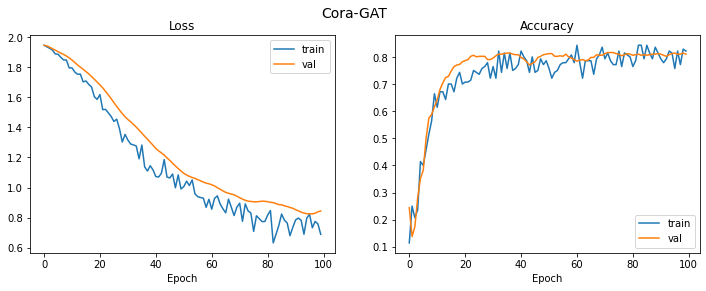

In [44]:
plt.figure(figsize=(12, 4))
plot_history(history, "Cora-GAT")

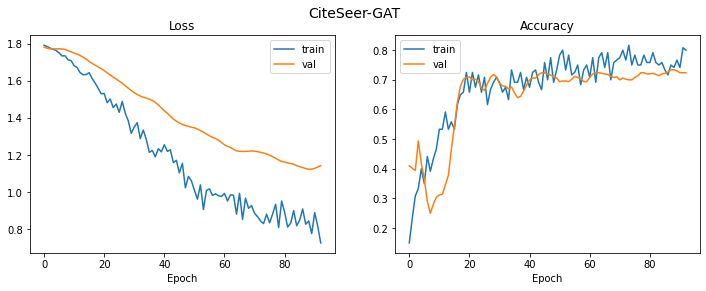

In [45]:
plt.figure(figsize=(12, 4))
plot_history(history2, "CiteSeer-GAT")

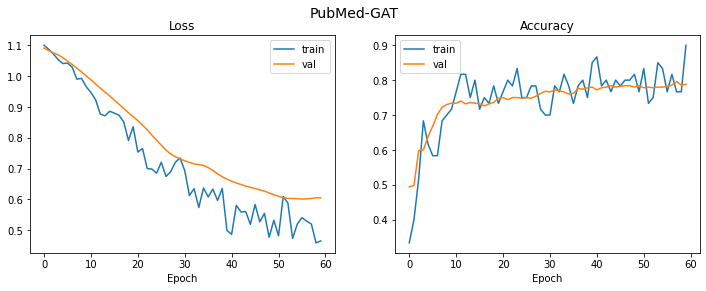

In [46]:
plt.figure(figsize=(12, 4))
plot_history(history3, "PubMed-GAT")